## <font color='darkblue'>Preface</font>
([article source](https://machinelearningmastery.com/the-transformer-positional-encoding-layer-in-keras-part-2/)) In [part 1: A gentle introduction to positional encoding in transformer models](https://nbviewer.ipython.org/github/johnklee/ml_articles/blob/master/mlmastery/A_gentle_introduction_to_positional_encoding_in_transformer_models_part1/notebook.ipynb#sect2), we discussed the positional encoding layer of the transformer model. We also showed how you can implement this layer and its functions yourself in Python. <b>In this tutorial, we’ll implement the positional encoding layer in Keras and Tensorflow. You can then use this layer in a complete transformer model.</b>

After completing this tutorial, you will know:
* Text vectorization in Keras
* Embedding layer in Keras
* How to subclass the embedding layer and write your own positional encoding layer.

### <font color='darkgreen'>Tutorial Overview</font>
This tutorial is divided into 3 parts; they are:
1. <b><font size='3ptx'><a href='#sect1'>Text vectorization and embedding layer in Keras</a></font></b>
2. <b><font size='3ptx'><a href='#sect2'>Writing your own positional encoding layer in Keras</a></font></b>
    * Randomly initialized and tunable embeddings
    * Fixed weight embeddings from Attention is All You Need
3. <b><font size='3ptx'><a href='#sect3'>Graphical view of the output of the positional encoding layer</a></font></b>

### <font color='darkgreen'>The Import Section</font>
First let’s write the section to import all the required libraries:

In [18]:
import tensorflow as tf
from tensorflow import convert_to_tensor, string
from tensorflow.keras.layers import TextVectorization, Embedding, Layer
from tensorflow.data import Dataset
import numpy as np
import matplotlib.pyplot as plt

<a id='sect1'></a>
## <font color='darkblue'>The Text Vectorization Layer</font>
* <b><a href='#sect1_1'>The Embedding Layer</a></b>
<br/>

We’ll start with a set of English phrases, which are already preprocessed and cleaned. The text vectorization layer creates a dictionary of words and replaces each word by its corresponding index in the dictionary. **Let’s see how we can map these two sentences using the text vectorization layer**:
* I am a robot
* you too robot

<br/>

<b>Note we have already converted the text to lowercase and removed all the punctuations and noise in text. We’ll convert these two phrases to vectors of a fixed length 5</b>. The [**TextVectorization**](https://www.tensorflow.org/api_docs/python/tf/keras/layers/TextVectorization) layer of Keras requires a maximum vocabulary size (<font color='violet'>max_tokens</font>) and the required length of output sequence (<font color='violet'>output_sequence_length</font>) for initialization. The output of the layer is a tensor of shape:
> (number of sentences, output sequence length)

<br/>

The following code snippet uses the adapt method to generate a vocabulary. It next creates a vectorized representation of text.

In [19]:
vocab_size = 10
output_sequence_length = 5
sentences = [["I am a robot"], ["you too robot"]]
sentence_data = Dataset.from_tensor_slices(sentences)
# Create the TextVectorization layer
vectorize_layer = TextVectorization(
                  output_sequence_length=output_sequence_length,
                  max_tokens=vocab_size)
# Train the layer to create a dictionary
vectorize_layer.adapt(sentence_data)
# Convert all sentences to tensors
word_tensors = convert_to_tensor(sentences, dtype=tf.string)
# Use the word tensors to get vectorized phrases
vectorized_words = vectorize_layer(word_tensors)
print("Vocabulary: ", vectorize_layer.get_vocabulary())
print("Vectorized words: ", vectorized_words)

Vocabulary:  ['', '[UNK]', 'robot', 'you', 'too', 'i', 'am', 'a']
Vectorized words:  tf.Tensor(
[[5 6 7 2 0]
 [3 4 2 0 0]], shape=(2, 5), dtype=int64)


<a id='sect1_1'></a>
### <font color='darkgreen'>The Embedding Layer</font>
<b>The Keras Embedding layer converts integers to dense vectors. </b> This layer maps these integers to random numbers, which are later tuned during the training phase. However, you also have the option to set the mapping to some predefined weight values (<font color='brown'>shown later</font>). To initialize this layer, we need to specify the maximum value of an integer to map, along with the length of the output sequence.

#### <font size='3ptx'>The Word Embeddings</font>
Let’s see how the layer converts our `vectorized_text` to tensors:

In [3]:
output_length = 6
word_embedding_layer = Embedding(vocab_size, output_length)
embedded_words = word_embedding_layer(vectorized_words)
print(embedded_words)

tf.Tensor(
[[[ 0.00159255  0.0237377   0.00592186  0.03066633  0.02824649
   -0.02402112]
  [-0.02659062 -0.00348645 -0.03330173 -0.01515425  0.02998136
   -0.00507959]
  [-0.01815591  0.0079321   0.01935692  0.00200195  0.04873777
    0.00636574]
  [ 0.03300695  0.01843351 -0.02699693 -0.00029789 -0.01380252
    0.00134264]
  [-0.00790211  0.02979622 -0.006251    0.03002688  0.04226694
   -0.00930872]]

 [[-0.01444093  0.02759412 -0.03056091 -0.01953631 -0.0488962
   -0.00861239]
  [ 0.04594969 -0.04480059  0.04507883 -0.03993602 -0.03007515
   -0.03806865]
  [ 0.03300695  0.01843351 -0.02699693 -0.00029789 -0.01380252
    0.00134264]
  [-0.00790211  0.02979622 -0.006251    0.03002688  0.04226694
   -0.00930872]
  [-0.00790211  0.02979622 -0.006251    0.03002688  0.04226694
   -0.00930872]]], shape=(2, 5, 6), dtype=float32)


#### <font size='3ptx'>The Position Embeddings</font>
We also need the embeddings for the corresponding positions. The maximum positions correspond to the output sequence length of the [**TextVectorization layer**](https://www.tensorflow.org/api_docs/python/tf/keras/layers/TextVectorization).

In [4]:
position_embedding_layer = Embedding(output_sequence_length, output_length)
position_indices = tf.range(output_sequence_length)
embedded_indices = position_embedding_layer(position_indices)
print(embedded_indices)

tf.Tensor(
[[-0.02082033 -0.04318792  0.03092572 -0.04108962 -0.01013154  0.02009343]
 [-0.04680616  0.03919676  0.02661523  0.02972138 -0.04719743  0.04678981]
 [ 0.02515086 -0.02363089  0.00996362 -0.03506092  0.04920613  0.01940448]
 [ 0.04553506  0.0063465  -0.03883425  0.00496538 -0.00587896  0.01884803]
 [ 0.01655377 -0.02659873 -0.04445714  0.00044848  0.01358939 -0.00027341]], shape=(5, 6), dtype=float32)


One example output is shown below:
![position embedding example](images/2.PNG)

### <font size='3ptx'>The Output of Positional Encoding Layer in Transformers</font>
In a transformer model the final output is the sum of both the word embeddings and the position embeddings. Hence, when you set up both embedding layers, you need to make sure that the `output_length` is the same for both:

In [5]:
final_output_embedding = embedded_words + embedded_indices
print("Final output: ", final_output_embedding)

Final output:  tf.Tensor(
[[[-0.01922778 -0.01945022  0.03684759 -0.01042329  0.01811495
   -0.00392769]
  [-0.07339678  0.03571031 -0.0066865   0.01456713 -0.01721606
    0.04171022]
  [ 0.00699495 -0.01569879  0.02932054 -0.03305897  0.09794389
    0.02577022]
  [ 0.07854202  0.02478002 -0.06583118  0.00466748 -0.01968148
    0.02019067]
  [ 0.00865166  0.00319749 -0.05070814  0.03047536  0.05585632
   -0.00958212]]

 [[-0.03526127 -0.01559379  0.00036481 -0.06062592 -0.05902774
    0.01148104]
  [-0.00085647 -0.00560383  0.07169405 -0.01021463 -0.07727257
    0.00872116]
  [ 0.05815782 -0.00519738 -0.01703331 -0.03535881  0.03540361
    0.02074713]
  [ 0.03763295  0.03614272 -0.04508525  0.03499226  0.03638798
    0.00953931]
  [ 0.00865166  0.00319749 -0.05070814  0.03047536  0.05585632
   -0.00958212]]], shape=(2, 5, 6), dtype=float32)


The output is shown below, annotated with my comments. Again, this will be different from your run of the code because of the random weight initialization:
![Final position embedding layer output](images/3.PNG)

<a id='sect2'></a>
## <font color='darkblue'>SubClassing the Keras Embedding Layer</font>
<b><font size='3ptx'>When implementing a transformer model, you’ll have to write your own position encoding layer.</font></b>

This is quite simple as the basic functionality is already provided for you. This Keras example shows how you can subclass the [**Embedding**](https://keras.io/api/layers/core_layers/embedding/) layer to implement your own functionality. You can add more methods to it as you require.

In [6]:
class PositionEmbeddingLayer(Layer):
    def __init__(self, sequence_length, vocab_size, output_dim, **kwargs):
        super(PositionEmbeddingLayer, self).__init__(**kwargs)
        self.word_embedding_layer = Embedding(
            input_dim=vocab_size, output_dim=output_dim
        )
        self.position_embedding_layer = Embedding(
            input_dim=sequence_length, output_dim=output_dim
        )

    def call(self, inputs):        
        position_indices = tf.range(tf.shape(inputs)[-1])
        embedded_words = self.word_embedding_layer(inputs)
        embedded_indices = self.position_embedding_layer(position_indices)
        return embedded_words + embedded_indices

Let’s run this layer:

In [7]:
my_embedding_layer = PositionEmbeddingLayer(output_sequence_length,
                                            vocab_size, output_length)

embedded_layer_output = my_embedding_layer(vectorized_words)
print("Output from my_embedded_layer: ", embedded_layer_output)

Output from my_embedded_layer:  tf.Tensor(
[[[-0.01124736  0.02593747 -0.06810233 -0.03932019  0.09092823
   -0.01732073]
  [ 0.04746041  0.06779587 -0.01871127  0.0318888   0.01092607
    0.00419025]
  [-0.02089459 -0.00541897 -0.03820211  0.01298565 -0.00627899
    0.05288449]
  [ 0.01188883  0.02479108  0.02228631 -0.0142432  -0.02231615
   -0.05673711]
  [-0.03524917  0.02475162 -0.00502949 -0.00772779 -0.02771302
   -0.02123171]]

 [[-0.0792498   0.06446094 -0.00887503 -0.03089676  0.08450408
   -0.0160342 ]
  [ 0.07095969  0.07137029 -0.02816767  0.00542819 -0.08403958
    0.00589749]
  [ 0.00682367  0.02527088 -0.01284612  0.00982421  0.03484458
   -0.04207659]
  [ 0.00826899  0.04446514 -0.04583046  0.06557745 -0.01909726
    0.00252078]
  [-0.03524917  0.02475162 -0.00502949 -0.00772779 -0.02771302
   -0.02123171]]], shape=(2, 5, 6), dtype=float32)


### <font color='darkgreen'>Positional Encoding in Transformers: Attention is All You Need</font>
<b><font size='3ptx'>Note, the above class creates an embedding layer that has trainable weights. Hence, the weights are initialized randomly and tuned in the training phase.</font></b>

The authors of [Attention is All You Need](https://arxiv.org/abs/1706.03762) have specified a positional encoding scheme as shown below. You can read the full details in [part 1](https://nbviewer.ipython.org/github/johnklee/ml_articles/blob/master/mlmastery/A_gentle_introduction_to_positional_encoding_in_transformer_models_part1/notebook.ipynb) of this tutorial:

![formula](https://nbviewer.ipython.org/github/johnklee/ml_articles/blob/master/mlmastery/A_gentle_introduction_to_positional_encoding_in_transformer_models_part1/images/3.PNG)

If you want to use the same positional encoding scheme, you can specify your own embedding matrix as discussed in [part 1](https://nbviewer.ipython.org/github/johnklee/ml_articles/blob/master/mlmastery/A_gentle_introduction_to_positional_encoding_in_transformer_models_part1/notebook.ipynb), which shows how to create your own embeddings in NumPy. When specifying the Embedding layer, you need to provide the positional encoding matrix as weights along with `trainable=False`. Let’s create another positional embedding class that does exactly this.

In [9]:
class PositionEmbeddingFixedWeights(Layer):
    def __init__(self, sequence_length, vocab_size, output_dim, **kwargs):
        super(PositionEmbeddingFixedWeights, self).__init__(**kwargs)
        word_embedding_matrix = self._get_position_encoding(vocab_size, output_dim)   
        position_embedding_matrix = self._get_position_encoding(sequence_length, output_dim)                                          
        self.word_embedding_layer = Embedding(
            input_dim=vocab_size, output_dim=output_dim,
            weights=[word_embedding_matrix],
            trainable=False
        )
        self.position_embedding_layer = Embedding(
            input_dim=sequence_length, output_dim=output_dim,
            weights=[position_embedding_matrix],
            trainable=False
        )
             
    def _get_position_encoding(self, seq_len, d, n=10000):
        P = np.zeros((seq_len, d))
        for k in range(seq_len):
            for i in np.arange(int(d/2)):
                denominator = np.power(n, 2*i/d)
                P[k, 2*i] = np.sin(k/denominator)
                P[k, 2*i+1] = np.cos(k/denominator)
        return P


    def call(self, inputs):        
        position_indices = tf.range(tf.shape(inputs)[-1])
        embedded_words = self.word_embedding_layer(inputs)
        embedded_indices = self.position_embedding_layer(position_indices)
        return embedded_words + embedded_indices

Next, we set up everything to run this layer:

In [10]:
attnisallyouneed_embedding = PositionEmbeddingFixedWeights(output_sequence_length,
                                            vocab_size, output_length)

attnisallyouneed_output = attnisallyouneed_embedding(vectorized_words)
print("Output from my_embedded_layer: ", attnisallyouneed_output)

Output from my_embedded_layer:  tf.Tensor(
[[[-0.9589243   1.2836622   0.23000172  1.9731903   0.01077196
    1.9999421 ]
  [ 0.56205547  1.5004725   0.3213085   1.9603932   0.01508068
    1.9999142 ]
  [ 1.566284    0.3377554   0.41192317  1.9433732   0.01938933
    1.999877  ]
  [ 1.0504174  -1.4061394   0.2314966   1.9860148   0.01077211
    1.9999698 ]
  [-0.7568025   0.3463564   0.18459873  1.982814    0.00861763
    1.9999628 ]]

 [[ 0.14112     0.0100075   0.1387981   1.9903207   0.00646326
    1.9999791 ]
  [ 0.08466846 -0.11334133  0.23099795  1.9817369   0.01077207
    1.9999605 ]
  [ 1.8185948  -0.8322937   0.185397    1.9913884   0.00861771
    1.9999814 ]
  [ 0.14112     0.0100075   0.1387981   1.9903207   0.00646326
    1.9999791 ]
  [-0.7568025   0.3463564   0.18459873  1.982814    0.00861763
    1.9999628 ]]], shape=(2, 5, 6), dtype=float32)


<a id='sect3'></a>
## <font color='darkblue'>Visualizing the Final Embedding</font>
<b><font size='3ptx'>In order to visualize the embeddings, let’s take two bigger sentences, one technical and the other one just a quote. </font></b>

We’ll set up the [**TextVectorization**](https://www.tensorflow.org/api_docs/python/tf/keras/layers/TextVectorization) layer along with the positional encoding layer and see what the final output looks like.

In [15]:
technical_phrase = ("to understand machine learning algorithms you need"
    " to understand concepts such as gradient of a function "
    "Hessians of a matrix and optimization etc")
wise_phrase = ("patrick henry said give me liberty or give me death "
    "when he addressed the second virginia convention in march")

total_vocabulary = 200
sequence_length = 20
final_output_len = 50

phrase_vectorization_layer = TextVectorization(
                  output_sequence_length=sequence_length,
                  max_tokens=total_vocabulary)
# Learn the dictionary
phrase_vectorization_layer.adapt([technical_phrase, wise_phrase])
# Convert all sentences to tensors
phrase_tensors = convert_to_tensor([technical_phrase, wise_phrase], 
                                   dtype=tf.string)
# Use the word tensors to get vectorized phrases
vectorized_phrases = phrase_vectorization_layer(phrase_tensors)

random_weights_embedding_layer = PositionEmbeddingLayer(sequence_length, 
                                                        total_vocabulary,
                                                        final_output_len)
fixed_weights_embedding_layer = PositionEmbeddingFixedWeights(sequence_length, 
                                                        total_vocabulary,
                                                        final_output_len)
random_embedding = random_weights_embedding_layer(vectorized_phrases)
fixed_embedding = fixed_weights_embedding_layer(vectorized_phrases)

Now let’s see what the random embeddings look like for both phrases:

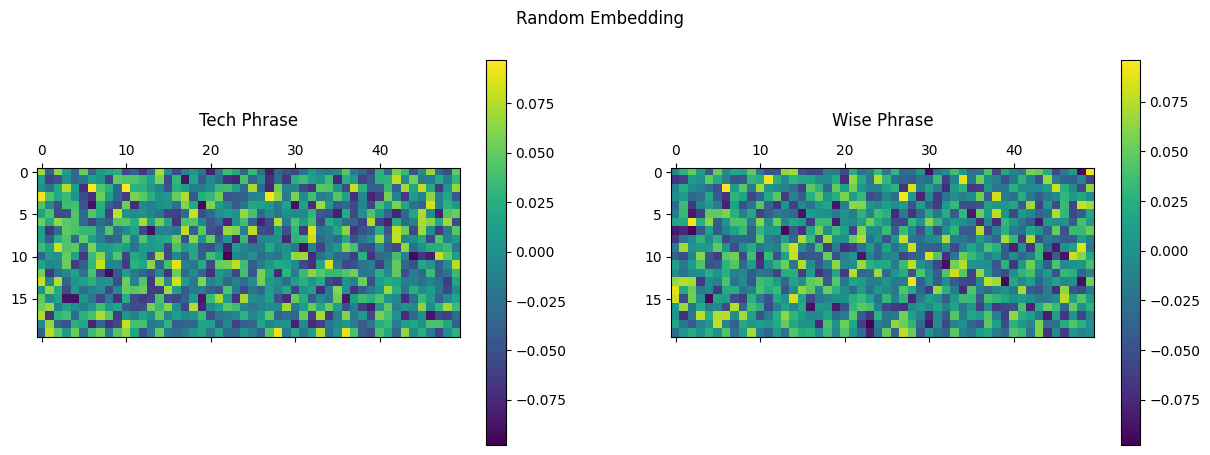

In [16]:
fig = plt.figure(figsize=(15, 5))    
title = ["Tech Phrase", "Wise Phrase"]
for i in range(2):
    ax = plt.subplot(1, 2, 1+i)
    matrix = tf.reshape(random_embedding[i, :, :], (sequence_length, final_output_len))
    cax = ax.matshow(matrix)
    plt.gcf().colorbar(cax)   
    plt.title(title[i], y=1.2)
fig.suptitle("Random Embedding")
plt.show()

The embedding from the fixed weights layer are visualized below:

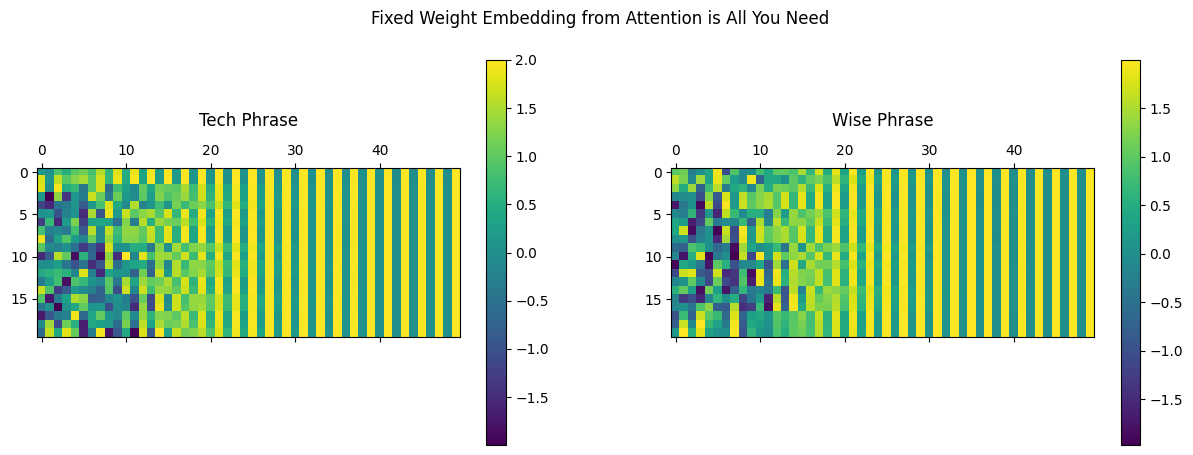

In [17]:
fig = plt.figure(figsize=(15, 5))    
title = ["Tech Phrase", "Wise Phrase"]
for i in range(2):
    ax = plt.subplot(1, 2, 1+i)
    matrix = tf.reshape(fixed_embedding[i, :, :], (sequence_length, final_output_len))
    cax = ax.matshow(matrix)
    plt.gcf().colorbar(cax)   
    plt.title(title[i], y=1.2)
fig.suptitle("Fixed Weight Embedding from Attention is All You Need")
plt.show()

We can see that the embedding layer initialized using the default parameter outputs random values. On the other hand, the fixed weights generated using sinusoids create a unique signature for every phrase with information on each word position encoded within it.

You can experiment with both tunable or fixed weight implementations for your particular application.

## <font color='darkblue'>Further Reading</font>
* **Books**
    * [Transformers for natural language processing, by Denis Rothman.](https://www.amazon.com/Transformers-Natural-Language-Processing-architectures/dp/1800565798)
* **Papers**
    * [Attention Is All You Need, 2017.](https://arxiv.org/abs/1706.03762)
* **Articles**
    * [The Transformer Attention Mechanism](https://machinelearningmastery.com/the-transformer-attention-mechanism/)
    * [The Transformer Model](https://machinelearningmastery.com/the-transformer-model/)
    * [Transformer Model for Language Understanding](https://www.tensorflow.org/text/tutorials/transformer)
    * [Using Pre-Trained Word Embeddings in a Keras Model](https://blog.keras.io/using-pre-trained-word-embeddings-in-a-keras-model.html)
    * [English-to-Spanish translation with a sequence-to-sequence Transformer](https://keras.io/examples/nlp/neural_machine_translation_with_transformer/)
    * [A Gentle Introduction to Positional Encoding in Transformer Models, Part 1](https://machinelearningmastery.com/a-gentle-introduction-to-positional-encoding-in-transformer-models-part-1)

## <font color='darkblue'>Supplement</font>
* [Google API Blog - Pathways Language Model (PaLM): Scaling to 540 Billion Parameters for Breakthrough Performance](https://ai.googleblog.com/2022/04/pathways-language-model-palm-scaling-to.html)
>  [GPT-3](https://arxiv.org/abs/2005.14165) first showed that large language models (LLMs) can be used for few-shot learning and can achieve impressive results without large-scale task-specific data collection or model parameter updating...